# Link Prediction Baselines
---
ROC AUC and Average Precision computed on Facebook dataset using these link prediction baselines:
1. Adamic-Adar
2. Jaccard Coefficient
3. Preferential Attachment

## 1. Read in Graph Data

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse as sp
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

In [2]:
EDGES_DIR = 'facebook/0.edges'

In [3]:
# Read edge-list
f = open(EDGES_DIR)
g_orig = nx.read_edgelist(f, nodetype=int)
g_adj = nx.to_numpy_matrix(g_orig) # convert to adjacency matrix (so node values become indices)
g = nx.from_numpy_matrix(g_adj) # re-create graph using node indices (0 to num_nodes-1)

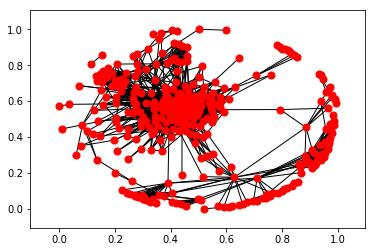

In [4]:
# draw network
nx.draw_networkx(g_orig, with_labels=False, node_size=50, node_color='r')
plt.show()

## 2. Preprocessing/Train-Test Split

In [5]:
from gae.preprocessing import mask_test_edges
np.random.seed(0) # make sure train-test split is consistent between notebooks
adj_sparse = nx.to_scipy_sparse_matrix(g)

# Perform train-test split
adj_train, train_edges, val_edges, val_edges_false, \
    test_edges, test_edges_false = mask_test_edges(adj_sparse, test_frac=.3, val_frac=.1)
g_train = nx.from_scipy_sparse_matrix(adj_train) # new graph object with only non-hidden edges

In [14]:
# Inspect train/test split
print "Total nodes:", adj_sparse.shape[0]
print "Total edges:", int(adj_sparse.nnz/2) # adj is symmetric, so nnz (num non-zero) = 2*num_edges
print "Training edges (positive):", len(train_edges)
print "Validation edges (positive):", len(val_edges)
print "Validation edges (negative):", len(val_edges_false)
print "Test edges (positive):", len(test_edges)
print "Test edges (negative):", len(test_edges_false)

Total nodes: 333
Total edges: 2519
Training edges (positive): 1513
Validation edges (positive): 251
Validation edges (negative): 251
Test edges (positive): 755
Test edges (negative): 755


In [7]:
def get_roc_score(edges_pos, edges_neg, score_matrix):
    # Store positive edge predictions, actual values
    preds_pos = []
    pos = []
    for edge in edges_pos:
        preds_pos.append(score_matrix[edge[0], edge[1]]) # predicted score
        pos.append(adj_sparse[edge[0], edge[1]]) # actual value (1 for positive)
        
    # Store negative edge predictions, actual values
    preds_neg = []
    neg = []
    for edge in edges_neg:
        preds_neg.append(score_matrix[edge[0], edge[1]]) # predicted score
        neg.append(adj_sparse[edge[0], edge[1]]) # actual value (0 for negative)
        
    # Calculate scores
    preds_all = np.hstack([preds_pos, preds_neg])
    labels_all = np.hstack([np.ones(len(preds_pos)), np.zeros(len(preds_neg))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)
    return roc_score, ap_score

## 3. Adamic-Adar

In [8]:
# Compute Adamic-Adar indexes from g_train
aa_matrix = np.zeros(g_adj.shape)
for u, v, p in nx.adamic_adar_index(g_train): # (u, v) = node indices, p = Adamic-Adar index
    aa_matrix[u][v] = p
    aa_matrix[v][u] = p # make sure it's symmetric
    
# Normalize array
aa_matrix = aa_matrix / aa_matrix.max()

In [15]:
# Calculate ROC AUC and Average Precision
aa_roc, aa_ap = get_roc_score(test_edges, test_edges_false, aa_matrix)

print 'Adamic-Adar Test ROC score: ', str(aa_roc)
print 'Adamic-Adar Test AP score: ', str(aa_ap)

Adamic-Adar Test ROC score:  0.914716898382
Adamic-Adar Test AP score:  0.927809386684


## 4. Jaccard Coefficient

In [10]:
# Compute Jaccard Coefficients from g_train
jc_matrix = np.zeros(g_adj.shape)
for u, v, p in nx.jaccard_coefficient(g_train): # (u, v) = node indices, p = Jaccard coefficient
    jc_matrix[u][v] = p
    jc_matrix[v][u] = p # make sure it's symmetric
    
# Normalize array
jc_matrix = jc_matrix / jc_matrix.max()

In [11]:
# Calculate ROC AUC and Average Precision
jc_roc, jc_ap = get_roc_score(test_edges, test_edges_false, jc_matrix)

print 'Jaccard Coefficient Test ROC score: ', str(jc_roc)
print 'Jaccard Coefficient Test AP score: ', str(jc_ap)

Jaccard Coefficient Test ROC score: 0.911260909609
Jaccard Coefficient Test AP score: 0.920444735314


## 5. Preferential Attachment

In [12]:
# Calculate, store Adamic-Index scores in array
pa_matrix = np.zeros(g_adj.shape)
for u, v, p in nx.preferential_attachment(g_train): # (u, v) = node indices, p = Jaccard coefficient
    pa_matrix[u][v] = p
    pa_matrix[v][u] = p # make sure it's symmetric
    
# Normalize array
pa_matrix = pa_matrix / pa_matrix.max()

In [16]:
# Calculate ROC AUC and Average Precision
pa_roc, pa_ap = get_roc_score(test_edges, test_edges_false, pa_matrix)

print 'Preferential Attachment Test ROC score: ', str(pa_roc)
print 'Preferential Attachment Test AP score: ', str(pa_ap)

Preferential Attachment Test ROC score:  0.822678829876
Preferential Attachment Test AP score:  0.833187188498
